In [1]:
from platform import python_version
import tensorflow as tf

print(tf.test.is_gpu_available())
print(python_version())

True
3.7.5


In [2]:
import os
import numpy as np
from os import listdir
from PIL import Image
import time
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from keras import backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
path="datasets/TSKinFace_Data/TSKinFace_cropped/"
randomiser = np.random.RandomState(123)

In [40]:
img_size = 64
mean = 0.
std_dev = 0.02
lr = 0.00001
b1 = 0.9
b2 = 0.99
sd_random_normal_init = 0.02

EPOCHS = 100
batch = 64

In [41]:
def generate_image(family_dir, family_number, gender):
    dic={}
    sub = ["F" , "M", gender]
    family_pth = path+"/"+family_dir+"/" + family_dir + "-" + str(family_number) + "-"
    for ele in sub:
        addr = family_pth+ele+".jpg"
        original_img = np.array(Image.open(addr))
        if ele =='F':
            dic['father'] = original_img
        elif ele == 'M':
            dic['mother'] = original_img
        elif ele == 'S':
            dic['child'] = original_img    
            dic['gender']=np.zeros((original_img.shape))
        elif ele == 'D':
            dic['child'] = original_img    
            dic['gender'] = np.ones((original_img.shape))
    return [dic['father'],dic['mother'],dic['gender'],dic['child']]

def generate_batch(families_batch):
    np_images=[]
    for family in families_batch:
        res = generate_image(family[0], family[1], family[2])
        if( res != None):
            np_images.append(res)
    return np_images

In [42]:
all_families = []
for i in range(285):
    all_families.append(['FMS', i+1, 'S'])
for i in range(274):
    all_families.append(['FMD', i+1, 'D'])
for i in range(228):
    all_families.append(['FMSD', i+1, 'D'])  
    all_families.append(['FMSD', i+1, 'S'])  
randomiser.shuffle(all_families)
train_families = all_families[:-10]
test_families = all_families[-10:]

In [43]:
OUTPUT_CHANNELS = 3

In [44]:
def pre_gen_upsample(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ELU())

    return result

In [45]:
def Pre_Generator():
    
    up_stack_noise = [
    pre_gen_upsample(64,4,apply_batchnorm=True), #8x8x64
    pre_gen_upsample(32,4,apply_batchnorm=True), #16x16x32
    pre_gen_upsample(32,4,apply_batchnorm=True)  #32x32x32
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')
    
    noise = tf.keras.layers.Input(shape=(4,4,64))
    
    x = noise
    for up in up_stack_noise:
        x = up(x)
#     print(x.shape)
    output = last(x)
#     print(output.shape)
    return tf.keras.Model(inputs=noise, outputs=output)

In [46]:
def gen_downsample_parent(filters, size, apply_batchnorm=True, apply_dropout=False):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.ELU())
        
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(rate = 0.5))

    return result

In [47]:
def gen_upsample(filters, size,apply_batchnorm = False,is_training = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False, trainable = is_training))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization(trainable = is_training))
        result.add(tf.keras.layers.ELU(trainable = is_training))

    return result

In [48]:
def EncoderNN():
    down_stack_parent = [
    gen_downsample_parent(32,4,apply_batchnorm=True, apply_dropout=False),
    gen_downsample_parent(64,4,apply_batchnorm=True, apply_dropout=False)
    ]
    
    down_stack_noise =[
    gen_upsample(64,4,apply_batchnorm=True,is_training = False), #8x8x64
    gen_upsample(32,4,apply_batchnorm=True,is_training = False) #16x16x32      
    ]
    
    final_conv =[
        gen_upsample(32,4 ,apply_batchnorm = True,is_training = True)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

    concat = tf.keras.layers.Concatenate()

    father = tf.keras.layers.Input(shape=(img_size,img_size,3))
    mother = tf.keras.layers.Input(shape=(img_size,img_size,3))
    noise = tf.keras.layers.Input(shape=(4,4,64))
    
    
    
    
    x1 = father
    for down in down_stack_parent:
        x1 = down(x1)
    
#     print(x1.shape)
    
    x2 = mother
    for down in down_stack_parent:
        x2 = down(x2) 
    
    x3 = noise
    for down in down_stack_noise:
        x3 = down(x3)
#     print(x3.shape)
    
#     print(x2.shape)
    
    final = concat([x1,x2,x3])
    final = final_conv[0](final)
    final = last(final)
    
#     print(final.shape)
    return tf.keras.Model(inputs=[father, mother, noise], outputs=final)

In [49]:
pre_gen = Pre_Generator()
pre_gen.load_weights('checkpoint/pre_gan_weights/epoch_29_preG.pth')
pre_gen.summary()

supervised = EncoderNN()
supervised.summary()

supervised.layers[4].set_weights(pre_gen.layers[1].get_weights())
supervised.layers[6].set_weights(pre_gen.layers[2].get_weights())


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 4, 4, 64)]        0         
_________________________________________________________________
sequential_13 (Sequential)   (None, 8, 8, 64)          65792     
_________________________________________________________________
sequential_14 (Sequential)   (None, 16, 16, 32)        32896     
_________________________________________________________________
sequential_15 (Sequential)   (None, 32, 32, 32)        16512     
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 64, 64, 3)         1539      
Total params: 116,739
Trainable params: 116,483
Non-trainable params: 256
_________________________________________________________________
Model: "model_4"
__________________________________________________________________________________________________
L

In [50]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1=b1)

In [51]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [52]:
def train_encoder(father_batch, mother_batch, noise, target_batch, b_size):
    with tf.GradientTape() as enc_tape:
        gen_outputs = supervised([father_batch, mother_batch, noise], training=True)
        
        diff = tf.abs(target_batch - gen_outputs)
        flatten_diff = tf.reshape(diff, (b_size, img_size*img_size*3))
        
        encoder_loss_batch = tf.reduce_mean(flatten_diff, axis=1)**0.5
        encoder_loss = tf.reduce_mean(encoder_loss_batch)
    
    print("ENCODER_LOSS: ",tensor_to_array(encoder_loss))
    #calculate gradients
    encoder_gradients = enc_tape.gradient(encoder_loss,supervised.trainable_variables)

    #apply gradients on optimizer
    encoder_optimizer.apply_gradients(zip(encoder_gradients,supervised.trainable_variables))
    


In [53]:
def fit_encoder(train_ds, epochs, test_ds, batch):
    losses=np.array([])
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch+1))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
            batch_data = batch_data / 255 * 2 -1
            
            
            print("Generated batch", batch_data.shape)
            
            X_Father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_Mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            
            noise = tf.random.normal((batch,4,4,64),mean= 0.0, stddev=1.0)

            
            train_encoder(X_Father_train, X_Mother_train, noise, Y_train,batch)
            
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
    print("______________________________TRAINING COMPLETED_______________________________")

In [54]:
train_dataset = all_families[:-100]
test_dataset = all_families[-100:]
supervised = EncoderNN()

with tf.device('/gpu:0'):
    fit_encoder(train_dataset, EPOCHS, test_dataset,batch)

______________________________EPOCH 1_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6748339
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6774583
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.68735135
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6658889
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6759002
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.66510904
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6575391
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.66368216
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.66553164
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6677608
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.669919
Trained for batch 11/14
Generated bat

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.62580514
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6312092
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6294494
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6252026
Trained for batch 14/14
______________________________EPOCH 8_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6168816
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.62455404
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.629236
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.61011565
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.62233543
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.61147475
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6140729
Trained for batch 7/14
Generated 

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5910348
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5971296
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.59508365
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6000595
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6008225
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6025289
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.60722035
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6055007
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6063411
Trained for batch 14/14
______________________________EPOCH 15_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.59252304
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6029433
Trained for batch 2/14
Generated

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.58157825
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5933089
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5916674
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57549024
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5892794
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5784564
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5864136
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5832549
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5888394
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.589221
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5910003
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5950763
Trained for batch 12/14


Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5845238
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.58778405
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.585462
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.58981764
Trained for batch 14/14
______________________________EPOCH 28_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57279783
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.58573085
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.58256197
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56684613
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.58088255
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.570238
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5793879
Trained for batch 7/14
Generate

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57563084
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56528914
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5748328
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5699898
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5765805
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5773873
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5791079
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5814855
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57890344
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5844531
Trained for batch 14/14
______________________________EPOCH 35_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56650543
Trained for batch 1/14
Generate

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5622236
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57641006
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5723934
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5563903
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57081467
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5609731
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57048035
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5652017
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5721557
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5733838
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5750186
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5766695
Trained for batch 12/1

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.570568
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5721135
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57323945
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5703912
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57724893
Trained for batch 14/14
______________________________EPOCH 48_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5580629
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57266796
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5686931
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5523504
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5669296
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5575555
Trained for batch 6/14
Generated 

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5640765
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5551493
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56407595
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5583385
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5658217
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56781733
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5691922
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56984025
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.566975
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5743042
Trained for batch 14/14
______________________________EPOCH 55_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55456746
Trained for batch 1/14
Generated

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5721177
Trained for batch 14/14
______________________________EPOCH 61_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55194414
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5672212
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5634946
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54647386
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5612045
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5527871
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56132025
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.555374
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56312984
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56543267
Trained for batch 10/14
Generated b

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56368
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.564651
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5647707
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5620483
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56994146
Trained for batch 14/14
______________________________EPOCH 68_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54925334
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5648559
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5613025
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54397136
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.558784
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5508537
Trained for batch 6/14
Generated bat

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5569368
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5494163
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5572602
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5508587
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55913997
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5618541
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56262857
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56248677
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55992347
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5680976
Trained for batch 14/14
______________________________EPOCH 75_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5469419
Trained for batch 1/14
Generate

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56669223
Trained for batch 14/14
______________________________EPOCH 81_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54516315
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5612756
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55799234
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5401315
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5550648
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.547912
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5555044
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5488161
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5573971
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5602293
Trained for batch 10/14
Generated bat

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5560686
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55895305
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55943406
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55895126
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5566771
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5652525
Trained for batch 14/14
______________________________EPOCH 88_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54332995
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5596793
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5565232
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53846496
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55336374
Trained for batch 5/14
Genera

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55536723
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5371306
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55210114
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54568946
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5528141
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54560435
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55469143
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55762506
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5579872
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5573441
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55521375
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56400186
Trained for bat

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5560889
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55405974
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5630368
Trained for batch 14/14
______________________________TRAINING COMPLETED_______________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


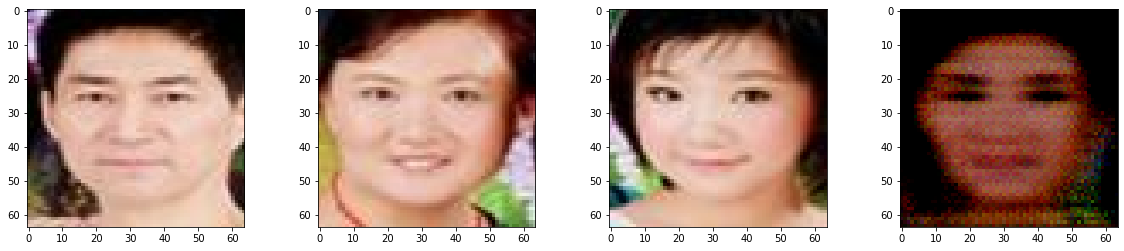

In [68]:
family_no = 1011
family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
noise = tf.random.normal((1,4,4,64),mean= 0.0, stddev=1.0)

with tf.device('/gpu:0'):
    gen_output = supervised([father_inp, mother_inp,noise], training=True)
temp = gen_output.numpy()
fig = plt.figure(figsize=(20, 4))
fig.add_subplot(1,4,1)
plt.imshow(family_data[0])
fig.add_subplot(1,4,2)
plt.imshow(family_data[1])
fig.add_subplot(1,4,3)
plt.imshow(family_data[3])
fig.add_subplot(1,4,4)
plt.imshow(np.squeeze(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


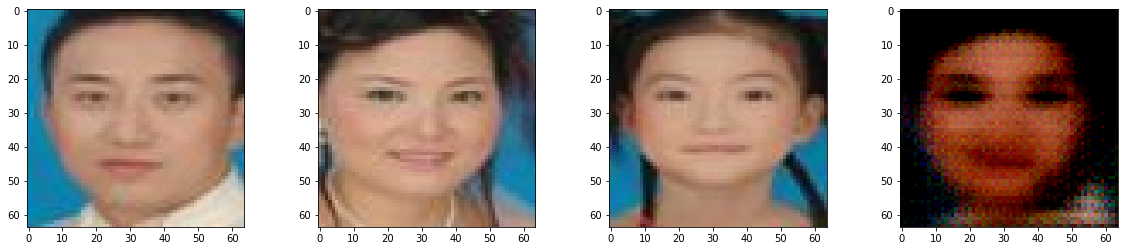

In [69]:
family_no = 1003
family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
noise = tf.random.normal((1,4,4,64),mean= 0.0, stddev=1.0)

with tf.device('/gpu:0'):
    gen_output = supervised([father_inp, mother_inp,noise], training=True)
temp = gen_output.numpy()
fig = plt.figure(figsize=(20, 4))
fig.add_subplot(1,4,1)
plt.imshow(family_data[0])
fig.add_subplot(1,4,2)
plt.imshow(family_data[1])
fig.add_subplot(1,4,3)
plt.imshow(family_data[3])
fig.add_subplot(1,4,4)
plt.imshow(np.squeeze(temp))

###############################################################################################################################

In [70]:
def disc_downsample_parent_target(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))

    return result

In [71]:
def disc_loss(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))
    
    return result

In [72]:
def Discriminator():

    father = tf.keras.layers.Input(shape=(img_size,img_size,3))
    mother = tf.keras.layers.Input(shape=(img_size,img_size,3))
    target = tf.keras.layers.Input(shape=(img_size,img_size,3))
    
    down_stack_parent_target = [
    disc_downsample_parent_target(32,4,apply_batchnorm=False), #32x32x32
    disc_downsample_parent_target(64,4,apply_batchnorm=True)   #16x16x64
    ]
    
    down_stack_combined =[
    disc_loss(192,4,apply_batchnorm=True),
    disc_loss(256,4,apply_batchnorm=False)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,padding='same',
                                  kernel_initializer=initializer) # linear layer
    
    
    concat = tf.keras.layers.Concatenate()
    x1 = father
    for down in down_stack_parent_target:
        x1 = down(x1)
    
    x2 = mother
    for down in down_stack_parent_target:
        x2 = down(x2)
        
    x3 = target
    for down in down_stack_parent_target:
        x3 = down(x3)
    
    combined = concat([x1,x2,x3])
    # combined is Batchx16x16x192
    
    x4 = combined
    for down in down_stack_combined:
        x4 = down(x4)
#     print(x4.shape)
    
    output = last(x4) #4X4 
    print(output.shape)

    return tf.keras.Model(inputs=[father,mother,target], outputs=output)

In [73]:
# discriminator = Discriminator()
# encoder= EncoderNN()

In [74]:
LAMBDA = 100

In [75]:
kernel_size_disc = 4

In [76]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [77]:
def discriminator_loss(disc_real_output, disc_generated_output,b_size):
    real_loss_diff = tf.abs(tf.ones_like(disc_real_output) - disc_real_output)**2
    real_flatten_diff = tf.reshape(real_loss_diff, (b_size, kernel_size_disc*kernel_size_disc*1))
    real_loss_batch = tf.reduce_mean(real_flatten_diff, axis=1)
    real_loss = tf.reduce_mean(real_loss_batch)
    print(real_loss.numpy().shape)
    
    gen_loss_diff = tf.abs(tf.zeros_like(disc_generated_output) - disc_generated_output)**2
    gen_flatten_diff = tf.reshape(gen_loss_diff, (b_size, kernel_size_disc*kernel_size_disc*1))
    gen_loss_batch = tf.reduce_mean(gen_flatten_diff, axis=1)
    gen_loss = tf.reduce_mean(gen_loss_batch)
#     print("gen_loss:",gen_loss)

    total_disc_loss = real_loss + gen_loss
    return total_disc_loss

In [78]:
def generator_loss(disc_generated_output, gen_output, target,b_size):
    gen_loss_diff = tf.abs(tf.ones_like(disc_generated_output) - disc_generated_output)**2
    gen_flatten_diff = tf.reshape(gen_loss_diff, (b_size, kernel_size_disc*kernel_size_disc*1))
    gen_loss_batch = tf.reduce_mean(gen_flatten_diff, axis=1)
    gen_loss = tf.reduce_mean(gen_loss_batch)
    
    l1_loss_diff = tf.abs(target - gen_output)**2
    l1_flatten_diff = tf.reshape(l1_loss_diff, (b_size, img_size*img_size*3))
    l1_loss_batch = tf.reduce_mean(l1_flatten_diff, axis=1)
    l1_loss = tf.reduce_mean(l1_loss_batch)

    
    total_gen_loss = l1_loss + LAMBDA * gen_loss  
#     print("Reconstruction loss: {}, GAN loss: {}".format(l1_loss, gen_loss))
    return total_gen_loss

In [79]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1 ,beta_2 = b2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1, beta_2 = b2)

In [80]:
def train_step(father_batch, mother_batch, noise, target_batch,b_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_outputs = unsupervised([father_batch, mother_batch,noise], training=True)
#         print("Generated outputs",gen_outputs.shape)
        
        disc_real_output = discriminator([father_batch, mother_batch, target_batch], training=True)
#         print("disc_real_output ", disc_real_output.shape)
        
        disc_generated_output = discriminator([father_batch, mother_batch, gen_outputs], training=True)
#         print("disc_generated_output ", disc_generated_output.shape)
        
        gen_loss =  generator_loss(disc_generated_output, gen_outputs, target_batch,b_size)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output,b_size)
    
        
    print("GEN_LOSS",tensor_to_array(gen_loss))
    print("DISC_LOSS",tensor_to_array(disc_loss))

    generator_gradients = gen_tape.gradient(gen_loss,unsupervised.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,unsupervised.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

In [81]:
def fit(train_ds, epochs, test_ds,batch):
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
#             batch_data = batch_data / 255 * 2 -1
            
            print("Generated batch", batch_data.shape)

            X_father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
            
            noise = tf.random.normal((batch,4,4,64),mean= 0.0, stddev=1.0)
            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            train_step(X_father_train, X_mother_train, noise, Y_train, batch)
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
            
    print("______________________________TRAINING COMPLETED_______________________________")
    checkpoint.save(file_prefix = checkpoint_prefix)

In [82]:
concat = tf.keras.layers.Concatenate()

In [83]:
train_dataset = all_families[:-10]
test_dataset = all_families[-10:]
pre_gen = Pre_Generator()
pre_gen.load_weights('checkpoint/pre_gan_weights/epoch_29_preG.pth')
# pre_gen.summary()

unsupervised = EncoderNN()
# unsupervised.summary()

unsupervised.layers[4].set_weights(pre_gen.layers[1].get_weights())
unsupervised.layers[6].set_weights(pre_gen.layers[2].get_weights())

discriminator = Discriminator()

(None, 4, 4, 1)


In [84]:
img_size = 64
mean = 0.
std_dev = 0.02
lr = 0.0005
b1 = 0.9
b2 = 0.99
sd_random_normal_init = 0.02

EPOCHS = 150
batch = 64

In [85]:
checkpoint_dir = './checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=unsupervised,
                                 discriminator=discriminator)

In [86]:
with tf.device('/gpu:0'):
    fit(train_dataset, EPOCHS, test_dataset,batch)

______________________________EPOCH 0_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19000.457
DISC_LOSS 3.6212358
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20385.104
DISC_LOSS 3.235018
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20431.836
DISC_LOSS 2.9030848
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19656.264
DISC_LOSS 2.4719205
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20823.123
DISC_LOSS 2.250589
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20638.818
DISC_LOSS 1.9768363
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20132.703
DISC_LOSS 1.792463
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18733.955
DISC_LOSS 1.5468998
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20623.63
DISC_LOSS 1.3680153
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)


Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19482.504
DISC_LOSS 0.2554093
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20666.635
DISC_LOSS 0.25818497
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20506.535
DISC_LOSS 0.2713647
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20016.932
DISC_LOSS 0.28015378
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18636.771
DISC_LOSS 0.25260174
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20542.521
DISC_LOSS 0.25698233
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20499.934
DISC_LOSS 0.25356686
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18682.129
DISC_LOSS 0.24486169
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19596.547
DISC_LOSS 0.24523397
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21283.143
DISC_LOSS 

GEN_LOSS 20028.621
DISC_LOSS 0.13817516
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18649.787
DISC_LOSS 0.11795641
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20554.818
DISC_LOSS 0.1217455
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20510.98
DISC_LOSS 0.120953634
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18693.2
DISC_LOSS 0.120192334
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19608.121
DISC_LOSS 0.121890716
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21293.652
DISC_LOSS 0.12387885
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20155.06
DISC_LOSS 0.11777414
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20530.09
DISC_LOSS 0.118968874
Trained for batch 15/15
______________________________EPOCH 11_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18760.22

GEN_LOSS 20513.639
DISC_LOSS 0.076155216
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18696.213
DISC_LOSS 0.07757222
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19610.922
DISC_LOSS 0.077869736
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21296.414
DISC_LOSS 0.07879804
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20156.96
DISC_LOSS 0.07419765
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20531.748
DISC_LOSS 0.07845226
Trained for batch 15/15
______________________________EPOCH 16_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18761.955
DISC_LOSS 0.0746563
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20174.533
DISC_LOSS 0.07321948
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20241.686
DISC_LOSS 0.075042866
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19497

()
GEN_LOSS 21294.031
DISC_LOSS 0.057125688
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20154.975
DISC_LOSS 0.053781435
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20529.201
DISC_LOSS 0.057412576
Trained for batch 15/15
______________________________EPOCH 21_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18759.643
DISC_LOSS 0.054840133
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20173.191
DISC_LOSS 0.05280552
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20239.5
DISC_LOSS 0.05413512
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19496.717
DISC_LOSS 0.051883213
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20679.303
DISC_LOSS 0.0526693
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20519.797
DISC_LOSS 0.055224355
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 200

()
GEN_LOSS 18757.195
DISC_LOSS 0.041251376
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20171.184
DISC_LOSS 0.040004596
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20237.504
DISC_LOSS 0.040474705
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19494.426
DISC_LOSS 0.039216816
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20676.52
DISC_LOSS 0.039537445
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20516.67
DISC_LOSS 0.040762756
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20026.945
DISC_LOSS 0.04416966
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18646.457
DISC_LOSS 0.03779941
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20552.75
DISC_LOSS 0.038518675
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20508.033
DISC_LOSS 0.0384328
Trained for batch 10/15
Generated batch (64, 

Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19492.082
DISC_LOSS 0.031185407
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20673.736
DISC_LOSS 0.031330667
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20513.508
DISC_LOSS 0.031712208
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20022.916
DISC_LOSS 0.033912092
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18643.377
DISC_LOSS 0.02954007
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20549.959
DISC_LOSS 0.03035724
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20505.236
DISC_LOSS 0.030544143
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18686.465
DISC_LOSS 0.030621441
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19602.545
DISC_LOSS 0.03081206
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21287.756
DISC_LOSS 0.031224888
Tra

Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20020.098
DISC_LOSS 0.026426429
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18639.438
DISC_LOSS 0.023652796
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20546.838
DISC_LOSS 0.024265513
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20502.764
DISC_LOSS 0.0240152
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18683.709
DISC_LOSS 0.025159094
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19600.555
DISC_LOSS 0.02437947
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21285.21
DISC_LOSS 0.024707641
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20146.902
DISC_LOSS 0.02347874
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20520.523
DISC_LOSS 0.024794227
Trained for batch 15/15
______________________________EPOCH 37_______________________________
Generated b

()
GEN_LOSS 20543.688
DISC_LOSS 0.019641794
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20499.982
DISC_LOSS 0.018960187
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18681.338
DISC_LOSS 0.02076238
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19597.076
DISC_LOSS 0.019650355
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21281.691
DISC_LOSS 0.019713141
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20143.172
DISC_LOSS 0.018907497
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20516.863
DISC_LOSS 0.020064387
Trained for batch 15/15
______________________________EPOCH 42_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18746.826
DISC_LOSS 0.019296415
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20162.898
DISC_LOSS 0.01964659
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_L

Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19593.701
DISC_LOSS 0.01590591
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21277.943
DISC_LOSS 0.016262215
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20138.936
DISC_LOSS 0.015664302
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20513.158
DISC_LOSS 0.016459806
Trained for batch 15/15
______________________________EPOCH 47_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18743.3
DISC_LOSS 0.015985426
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20159.344
DISC_LOSS 0.016449519
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20223.424
DISC_LOSS 0.014841713
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19481.13
DISC_LOSS 0.0155656515
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20661.678
DISC_LOSS 0.015582563
Trained for batch 5/15
Generated b

Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20134.633
DISC_LOSS 0.013094498
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20508.48
DISC_LOSS 0.013654541
Trained for batch 15/15
______________________________EPOCH 52_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18739.299
DISC_LOSS 0.013008727
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20155.785
DISC_LOSS 0.0140096685
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20219.29
DISC_LOSS 0.0124559505
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19477.225
DISC_LOSS 0.012645537
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20656.678
DISC_LOSS 0.012723887
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20496.88
DISC_LOSS 0.013484465
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20007.53
DISC_LOSS 0.0136926705
Trained for batch 7/15
Generated b

()
GEN_LOSS 18735.072
DISC_LOSS 0.010947398
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20150.695
DISC_LOSS 0.011589543
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20213.002
DISC_LOSS 0.010359297
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19470.932
DISC_LOSS 0.010978129
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20651.59
DISC_LOSS 0.010834459
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20492.344
DISC_LOSS 0.011041287
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20003.988
DISC_LOSS 0.011198454
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18624.297
DISC_LOSS 0.010515293
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20531.36
DISC_LOSS 0.011096554
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20486.143
DISC_LOSS 0.010137598
Trained for batch 10/15
Generated batch 

()
GEN_LOSS 20207.889
DISC_LOSS 0.008591368
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19466.639
DISC_LOSS 0.009016344
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20646.87
DISC_LOSS 0.009278692
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20487.225
DISC_LOSS 0.009289218
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19998.887
DISC_LOSS 0.009464808
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18619.754
DISC_LOSS 0.008989576
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20526.828
DISC_LOSS 0.0093108285
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20481.799
DISC_LOSS 0.00846412
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18662.217
DISC_LOSS 0.009504668
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19577.967
DISC_LOSS 0.008976515
Trained for batch 12/15
Generated bat

()
GEN_LOSS 20483.096
DISC_LOSS 0.008081874
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19994.43
DISC_LOSS 0.008032523
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18615.73
DISC_LOSS 0.0077315625
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20522.43
DISC_LOSS 0.008087716
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20476.256
DISC_LOSS 0.0072194664
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18658.01
DISC_LOSS 0.008268748
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19573.51
DISC_LOSS 0.007659871
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21257.895
DISC_LOSS 0.007739757
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20120.217
DISC_LOSS 0.007565448
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20494.965
DISC_LOSS 0.008050613
Trained for batch 15/15
____________

Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20517.533
DISC_LOSS 0.0070699323
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20471.766
DISC_LOSS 0.0062848823
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18654.322
DISC_LOSS 0.0070443014
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19569.236
DISC_LOSS 0.0066941283
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21253.717
DISC_LOSS 0.0065710023
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20116.412
DISC_LOSS 0.006543398
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20490.521
DISC_LOSS 0.007030533
Trained for batch 15/15
______________________________EPOCH 73_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18720.996
DISC_LOSS 0.0067917053
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20136.016
DISC_LOSS 0.0071433405
Trained for batch 2/15

Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18649.355
DISC_LOSS 0.006136008
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19564.957
DISC_LOSS 0.0057765488
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21249.852
DISC_LOSS 0.005677899
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20112.232
DISC_LOSS 0.0056236587
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20486.627
DISC_LOSS 0.005980979
Trained for batch 15/15
______________________________EPOCH 78_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18716.496
DISC_LOSS 0.005994703
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20130.672
DISC_LOSS 0.006047868
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20193.852
DISC_LOSS 0.005372896
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19452.65
DISC_LOSS 0.00553705
Trained for batch 4/15
Generat

()
GEN_LOSS 21244.857
DISC_LOSS 0.005148471
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20108.72
DISC_LOSS 0.0048202877
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20482.484
DISC_LOSS 0.0053235553
Trained for batch 15/15
______________________________EPOCH 83_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18712.238
DISC_LOSS 0.0050682332
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20126.43
DISC_LOSS 0.0051882314
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20189.312
DISC_LOSS 0.00471704
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19447.947
DISC_LOSS 0.004870881
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20629.057
DISC_LOSS 0.0048898878
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20469.172
DISC_LOSS 0.0051892297
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN

Trained for batch 15/15
______________________________EPOCH 88_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18708.254
DISC_LOSS 0.0045325216
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20122.557
DISC_LOSS 0.004740444
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20184.84
DISC_LOSS 0.0041975924
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19442.938
DISC_LOSS 0.004285332
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20624.268
DISC_LOSS 0.0043759197
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20464.871
DISC_LOSS 0.004610135
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19976.85
DISC_LOSS 0.004482648
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18599.035
DISC_LOSS 0.0045222696
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20504.363
DISC_LOSS 0.004618168
Trained f

Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20180.398
DISC_LOSS 0.0037079188
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19439.066
DISC_LOSS 0.0037573068
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20620.105
DISC_LOSS 0.003926282
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20460.266
DISC_LOSS 0.0040481156
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19972.299
DISC_LOSS 0.00402115
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18594.725
DISC_LOSS 0.004037556
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20500.021
DISC_LOSS 0.004115857
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20453.342
DISC_LOSS 0.0035958178
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18636.01
DISC_LOSS 0.004123115
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19551.07

Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20616.0
DISC_LOSS 0.003566266
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20456.293
DISC_LOSS 0.0037557431
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19967.936
DISC_LOSS 0.0035358518
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18590.668
DISC_LOSS 0.0036561307
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20496.057
DISC_LOSS 0.0037571038
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20449.867
DISC_LOSS 0.0032109683
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18632.129
DISC_LOSS 0.0037203284
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19546.174
DISC_LOSS 0.0037112948
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21230.588
DISC_LOSS 0.003515921
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 200

Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19964.588
DISC_LOSS 0.0033156383
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18587.408
DISC_LOSS 0.0034495734
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20491.744
DISC_LOSS 0.0034852393
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20444.97
DISC_LOSS 0.003138821
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18627.955
DISC_LOSS 0.0033688387
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19542.783
DISC_LOSS 0.0033367733
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21226.814
DISC_LOSS 0.0032971408
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20090.023
DISC_LOSS 0.0030522998
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20464.479
DISC_LOSS 0.0033801775
Trained for batch 15/15
______________________________EPOCH 104______________________________

()
GEN_LOSS 18582.816
DISC_LOSS 0.003400013
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20488.746
DISC_LOSS 0.0036648633
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20442.75
DISC_LOSS 0.0029239212
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18625.184
DISC_LOSS 0.0034720718
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19538.348
DISC_LOSS 0.0034404956
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21221.307
DISC_LOSS 0.0034228507
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20084.309
DISC_LOSS 0.0029512653
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20460.072
DISC_LOSS 0.003323228
Trained for batch 15/15
______________________________EPOCH 109_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18693.088
DISC_LOSS 0.00346766
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
(

Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20433.852
DISC_LOSS 0.0038986877
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18619.477
DISC_LOSS 0.0035392265
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19536.21
DISC_LOSS 0.0032572877
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21220.723
DISC_LOSS 0.0031188154
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20083.475
DISC_LOSS 0.002873474
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20456.277
DISC_LOSS 0.0030104034
Trained for batch 15/15
______________________________EPOCH 114_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18686.365
DISC_LOSS 0.0029803796
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20097.943
DISC_LOSS 0.0029375732
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20162.533
DISC_LOSS 0.002921929

Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18619.438
DISC_LOSS 0.0033544672
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19534.967
DISC_LOSS 0.0036310498
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21217.678
DISC_LOSS 0.003392158
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20078.467
DISC_LOSS 0.0028336502
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20450.238
DISC_LOSS 0.0032121656
Trained for batch 15/15
______________________________EPOCH 119_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18680.535
DISC_LOSS 0.0035799844
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20092.637
DISC_LOSS 0.0028386796
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20158.29
DISC_LOSS 0.0028803397
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19420.316
DISC_LOSS 0.0033640387
Trained for batch 4/15

Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21213.963
DISC_LOSS 0.0034044262
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20074.717
DISC_LOSS 0.0029540812
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20446.277
DISC_LOSS 0.0033433852
Trained for batch 15/15
______________________________EPOCH 124_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18676.744
DISC_LOSS 0.003715783
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20089.271
DISC_LOSS 0.0027506992
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20155.082
DISC_LOSS 0.0026479599
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19416.914
DISC_LOSS 0.0031385622
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20597.453
DISC_LOSS 0.003536633
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20435.887
DISC_LOSS 0.0033653663
Trained for batch 6/15
G

()
GEN_LOSS 20443.322
DISC_LOSS 0.003227177
Trained for batch 15/15
______________________________EPOCH 129_______________________________
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18674.266
DISC_LOSS 0.003489165
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20086.246
DISC_LOSS 0.0027180067
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20151.36
DISC_LOSS 0.0026399065
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19412.953
DISC_LOSS 0.0027866862
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20593.316
DISC_LOSS 0.003137789
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20431.893
DISC_LOSS 0.0031230033
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19942.207
DISC_LOSS 0.0031575633
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18563.402
DISC_LOSS 0.003324376
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN

Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20082.652
DISC_LOSS 0.0026766062
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20147.807
DISC_LOSS 0.0025809673
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19409.434
DISC_LOSS 0.0026530246
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20589.887
DISC_LOSS 0.0028895931
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20428.492
DISC_LOSS 0.00290878
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19938.73
DISC_LOSS 0.0029572747
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18560.023
DISC_LOSS 0.0031406982
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20463.477
DISC_LOSS 0.0029427118
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20419.908
DISC_LOSS 0.002612188
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18607.025
DISC_LOSS 0.0026731

Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19406.53
DISC_LOSS 0.0025895806
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20586.23
DISC_LOSS 0.0026493305
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20425.006
DISC_LOSS 0.0026183536
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19935.77
DISC_LOSS 0.0027276452
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18556.77
DISC_LOSS 0.0030594007
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20460.389
DISC_LOSS 0.0028103134
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20416.521
DISC_LOSS 0.0025347797
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18603.498
DISC_LOSS 0.0025812518
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19519.414
DISC_LOSS 0.002619542
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21201.328
DISC_LOSS 0.002515

()
GEN_LOSS 20422.088
DISC_LOSS 0.002517864
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19932.404
DISC_LOSS 0.0025215107
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18554.166
DISC_LOSS 0.0026792174
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20456.934
DISC_LOSS 0.0026190572
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20413.137
DISC_LOSS 0.0024705913
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18600.445
DISC_LOSS 0.0024311072
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19516.314
DISC_LOSS 0.0024461423
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21197.904
DISC_LOSS 0.0023825539
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20059.904
DISC_LOSS 0.002183728
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20431.766
DISC_LOSS 0.0026177135
Trained for batch 15/15
_

()
GEN_LOSS 18551.342
DISC_LOSS 0.0025455956
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20453.916
DISC_LOSS 0.0024794978
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20410.234
DISC_LOSS 0.0022813892
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 18597.428
DISC_LOSS 0.0023104653
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 19512.838
DISC_LOSS 0.0023084106
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 21194.045
DISC_LOSS 0.0022160893
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20056.576
DISC_LOSS 0.0020470591
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
()
GEN_LOSS 20428.91
DISC_LOSS 0.0023588107
Trained for batch 15/15
______________________________TRAINING COMPLETED_______________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


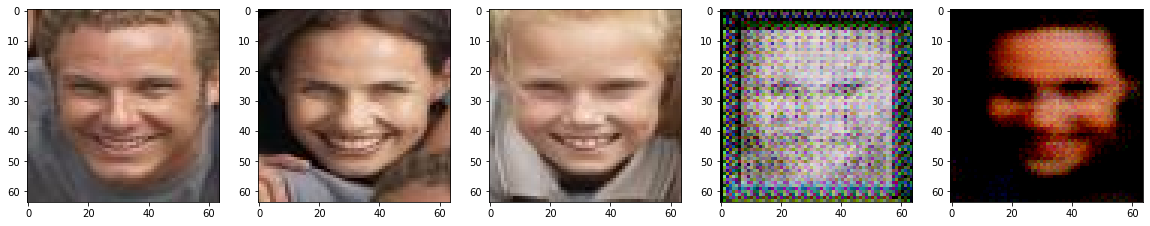

In [87]:
family_no = 1008
family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
noise = tf.random.normal((1,4,4,64),mean= 0.0, stddev=1.0)

with tf.device('/gpu:0'):
    gen_output_sup = supervised([father_inp, mother_inp,noise], training=True)
    gen_output = unsupervised([father_inp, mother_inp,noise], training=True)
temp = gen_output.numpy()
temp1 = gen_output_sup.numpy()
fig = plt.figure(figsize=(20, 4))
fig.add_subplot(1,5,1)
plt.imshow(family_data[0])
fig.add_subplot(1,5,2)
plt.imshow(family_data[1])
fig.add_subplot(1,5,3)
plt.imshow(family_data[3])
fig.add_subplot(1,5,4)
plt.imshow(np.squeeze(temp))
fig.add_subplot(1,5,5)
plt.imshow(np.squeeze(temp1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


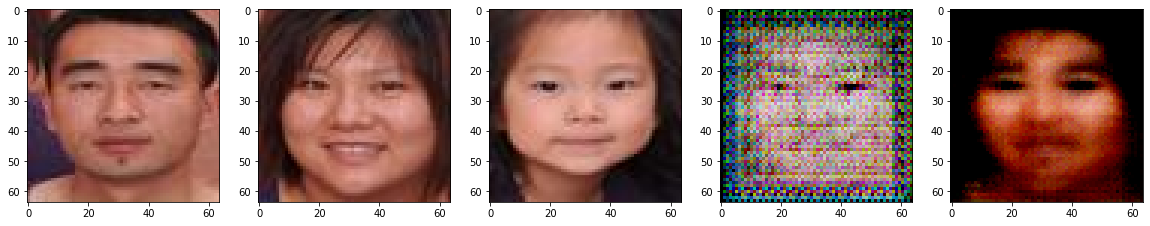

In [126]:
family_no = 1008
family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
noise = tf.random.normal((1,4,4,64),mean= 0.0, stddev=1.0)

with tf.device('/gpu:0'):
    gen_output_sup = supervised([father_inp, mother_inp,noise], training=True)
    gen_output = unsupervised([father_inp, mother_inp,noise], training=True)
temp = gen_output.numpy()
temp1 = gen_output_sup.numpy()
fig = plt.figure(figsize=(20, 4))
fig.add_subplot(1,5,1)
plt.imshow(family_data[0])
fig.add_subplot(1,5,2)
plt.imshow(family_data[1])
fig.add_subplot(1,5,3)
plt.imshow(family_data[3])
fig.add_subplot(1,5,4)
plt.imshow(np.squeeze(temp))
fig.add_subplot(1,5,5)
plt.imshow(np.squeeze(temp1))